# CIFAR-100 CNN Classification using PyTorch

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt

In [30]:
meta = torchvision.datasets.CIFAR10(root='./data', download=True)
classes = meta.classes
print(f"Total length: {len(meta)}")
print(f"Total classes: {len(classes)}")

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Total length: 50000
Total classes: 10


In [31]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)
data_dict = {'image': [], 'label': [], 'class_name': []}

for i in range(len(data)):
    img, label = data[i]
    data_dict['image'].append(img)
    data_dict['label'].append(label)
    data_dict['class_name'].append(classes[label])

df = pd.DataFrame(data_dict)
df.head()

,image,label,class_name
0,<PIL.Image.Image image mode=RGB size=32x32 at ...,6,frog
1,<PIL.Image.Image image mode=RGB size=32x32 at ...,9,truck
2,<PIL.Image.Image image mode=RGB size=32x32 at ...,9,truck
3,<PIL.Image.Image image mode=RGB size=32x32 at ...,4,deer
4,<PIL.Image.Image image mode=RGB size=32x32 at ...,1,automobile


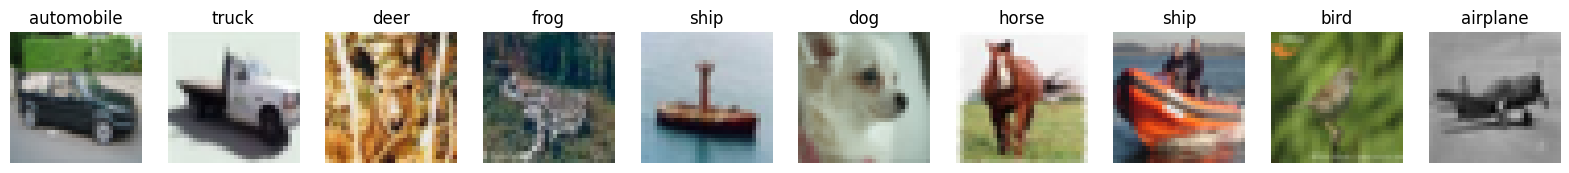

In [32]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    idx = np.random.randint(len(df))
    axes[i].imshow(df['image'][idx])
    axes[i].axis('off')
    axes[i].set_title(df['class_name'][idx])

In [33]:
from torchvision.transforms import ToTensor

tensor_data = [ToTensor()(img) for img in df['image']]
stacked = torch.stack(tensor_data)

mean = stacked.mean(dim=[0, 2, 3])
std = stacked.std(dim=[0, 2, 3])

print(f"Computed mean: {mean}")
print(f" Computed std: {std}")

Computed mean: tensor([0.4914, 0.4822, 0.4465])
 Computed std: tensor([0.2470, 0.2435, 0.2616])


In [34]:
from torchvision import transforms
from torch.utils.data import DataLoader

mean = mean.tolist()
std = std.tolist()

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [35]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # -> 4x4
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [38]:
patience = 10
epochs_no_improve = 0
best_val_acc = 0.0
early_stop = False

In [39]:
from tqdm import tqdm

num_epochs = 100
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(1, num_epochs + 1):
    if early_stop:
        print(f"Early stopping at epoch {epoch-1}")
        break

    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cifar10_model.pth')
        print("New best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        early_stop = True

Epoch 1 [Val]: 100%|██████████| 79/79 [00:02<00:00, 28.31it/s]


Epoch 1: Train Loss=1.8331, Val Loss=1.5413, Val Acc=52.89%
New best model saved.


Epoch 2 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.57it/s]


Epoch 2: Train Loss=1.5702, Val Loss=1.4067, Val Acc=60.34%
New best model saved.


Epoch 3 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.97it/s]


Epoch 3: Train Loss=1.4570, Val Loss=1.3187, Val Acc=65.41%
New best model saved.


Epoch 4 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.59it/s]


Epoch 4: Train Loss=1.3833, Val Loss=1.3324, Val Acc=63.57%
No improvement for 1 epochs.


Epoch 5 [Val]: 100%|██████████| 79/79 [00:03<00:00, 23.43it/s]


Epoch 5: Train Loss=1.3302, Val Loss=1.2435, Val Acc=68.20%
New best model saved.


Epoch 6 [Val]: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


Epoch 6: Train Loss=1.2828, Val Loss=1.1506, Val Acc=73.05%
New best model saved.


Epoch 7 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.34it/s]


Epoch 7: Train Loss=1.2528, Val Loss=1.1586, Val Acc=72.71%
No improvement for 1 epochs.


Epoch 8 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.17it/s]


Epoch 8: Train Loss=1.2155, Val Loss=1.1629, Val Acc=72.17%
No improvement for 2 epochs.


Epoch 9 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.40it/s]


Epoch 9: Train Loss=1.1804, Val Loss=1.1037, Val Acc=75.30%
New best model saved.


Epoch 10 [Val]: 100%|██████████| 79/79 [00:03<00:00, 22.30it/s]


Epoch 10: Train Loss=1.1533, Val Loss=1.0633, Val Acc=77.21%
New best model saved.


Epoch 11 [Val]: 100%|██████████| 79/79 [00:02<00:00, 27.51it/s]


Epoch 11: Train Loss=1.1302, Val Loss=1.0791, Val Acc=76.57%
No improvement for 1 epochs.


Epoch 12 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.31it/s]


Epoch 12: Train Loss=1.1033, Val Loss=1.0180, Val Acc=78.87%
New best model saved.


Epoch 13 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.37it/s]


Epoch 13: Train Loss=1.0709, Val Loss=1.0188, Val Acc=78.83%
No improvement for 1 epochs.


Epoch 14 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.47it/s]


Epoch 14: Train Loss=1.0503, Val Loss=1.0081, Val Acc=79.25%
New best model saved.


Epoch 15 [Val]: 100%|██████████| 79/79 [00:03<00:00, 21.75it/s]


Epoch 15: Train Loss=1.0185, Val Loss=0.9749, Val Acc=80.98%
New best model saved.


Epoch 16 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.84it/s]


Epoch 16: Train Loss=0.9976, Val Loss=0.9626, Val Acc=80.96%
No improvement for 1 epochs.


Epoch 17 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.59it/s]


Epoch 17: Train Loss=0.9745, Val Loss=0.9115, Val Acc=83.59%
New best model saved.


Epoch 18 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.28it/s]


Epoch 18: Train Loss=0.9506, Val Loss=0.9325, Val Acc=81.98%
No improvement for 1 epochs.


Epoch 19 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.11it/s]


Epoch 19: Train Loss=0.9283, Val Loss=0.8958, Val Acc=84.08%
New best model saved.


Epoch 20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.82it/s]


Epoch 20: Train Loss=0.9075, Val Loss=0.8774, Val Acc=85.16%
New best model saved.


Epoch 21 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.72it/s]


Epoch 21: Train Loss=0.8896, Val Loss=0.8672, Val Acc=85.59%
New best model saved.


Epoch 22 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.33it/s]


Epoch 22: Train Loss=0.8729, Val Loss=0.8722, Val Acc=85.10%
No improvement for 1 epochs.


Epoch 23 [Val]: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


Epoch 23: Train Loss=0.8584, Val Loss=0.8517, Val Acc=85.81%
New best model saved.


Epoch 24 [Val]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


Epoch 24: Train Loss=0.8378, Val Loss=0.8482, Val Acc=86.10%
New best model saved.


Epoch 25 [Val]: 100%|██████████| 79/79 [00:03<00:00, 21.69it/s]


Epoch 25: Train Loss=0.8244, Val Loss=0.8270, Val Acc=86.91%
New best model saved.


Epoch 26 [Val]: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s]


Epoch 26: Train Loss=0.8138, Val Loss=0.8232, Val Acc=87.16%
New best model saved.


Epoch 27 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.30it/s]


Epoch 27: Train Loss=0.8057, Val Loss=0.8168, Val Acc=87.43%
New best model saved.


Epoch 28 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.83it/s]


Epoch 28: Train Loss=0.7988, Val Loss=0.8137, Val Acc=87.45%
New best model saved.


Epoch 29 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.57it/s]


Epoch 29: Train Loss=0.7929, Val Loss=0.8098, Val Acc=87.56%
New best model saved.


Epoch 30 [Val]: 100%|██████████| 79/79 [00:03<00:00, 23.68it/s]


Epoch 30: Train Loss=0.7894, Val Loss=0.8089, Val Acc=87.67%
New best model saved.


Epoch 31 [Val]: 100%|██████████| 79/79 [00:02<00:00, 26.58it/s]


Epoch 31: Train Loss=0.7903, Val Loss=0.8089, Val Acc=87.67%
No improvement for 1 epochs.


Epoch 32 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.58it/s]


Epoch 32: Train Loss=0.7903, Val Loss=0.8092, Val Acc=87.65%
No improvement for 2 epochs.


Epoch 33 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.29it/s]


Epoch 33: Train Loss=0.7918, Val Loss=0.8101, Val Acc=87.84%
New best model saved.


Epoch 34 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.39it/s]


Epoch 34: Train Loss=0.7940, Val Loss=0.8108, Val Acc=87.63%
No improvement for 1 epochs.


Epoch 35 [Val]: 100%|██████████| 79/79 [00:03<00:00, 22.33it/s]


Epoch 35: Train Loss=0.8004, Val Loss=0.8143, Val Acc=87.53%
No improvement for 2 epochs.


Epoch 36 [Val]: 100%|██████████| 79/79 [00:03<00:00, 24.27it/s]


Epoch 36: Train Loss=0.8016, Val Loss=0.8245, Val Acc=87.02%
No improvement for 3 epochs.


Epoch 37 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.47it/s]


Epoch 37: Train Loss=0.8116, Val Loss=0.8343, Val Acc=86.89%
No improvement for 4 epochs.


Epoch 38 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.63it/s]


Epoch 38: Train Loss=0.8181, Val Loss=0.8274, Val Acc=87.47%
No improvement for 5 epochs.


Epoch 39 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


Epoch 39: Train Loss=0.8286, Val Loss=0.8409, Val Acc=86.49%
No improvement for 6 epochs.


Epoch 40 [Val]: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s]


Epoch 40: Train Loss=0.8451, Val Loss=0.8404, Val Acc=86.59%
No improvement for 7 epochs.


Epoch 41 [Val]: 100%|██████████| 79/79 [00:03<00:00, 22.54it/s]


Epoch 41: Train Loss=0.8615, Val Loss=0.8607, Val Acc=85.85%
No improvement for 8 epochs.


Epoch 42 [Val]: 100%|██████████| 79/79 [00:02<00:00, 30.47it/s]


Epoch 42: Train Loss=0.8768, Val Loss=0.8742, Val Acc=85.27%
No improvement for 9 epochs.


Epoch 43 [Val]: 100%|██████████| 79/79 [00:02<00:00, 29.64it/s]

Epoch 43: Train Loss=0.8926, Val Loss=0.8988, Val Acc=84.05%
No improvement for 10 epochs.
Early stopping at epoch 43


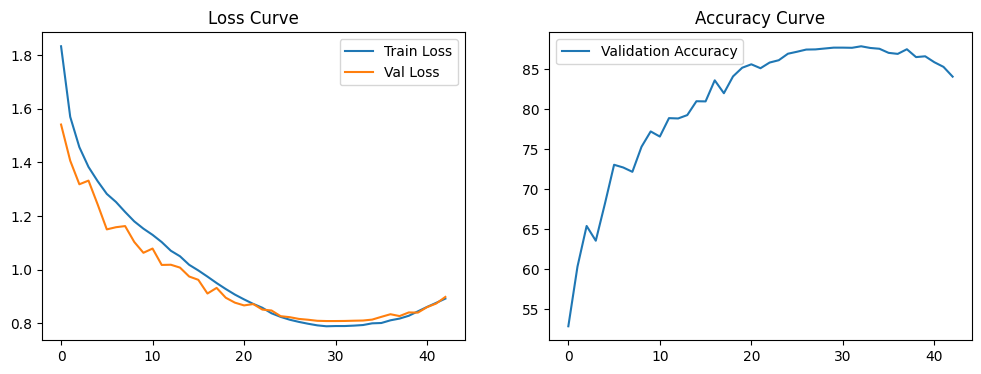

In [40]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

In [41]:
# Load best model
model.load_state_dict(torch.load("best_cifar10_model.pth"))

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100. * correct / total
    print(f"🎯 Final Test Accuracy: {acc:.2f}%")

evaluate(model, test_loader)


🎯 Final Test Accuracy: 87.84%
